## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
from sklearn.cluster import KMeans
from yellowbrick.cluster import InterclusterDistance
import folium
import unidecode

%matplotlib inline

pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

/home/guireis/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data_scaled=pd.read_csv('data_2/data_preprocess_scale.csv')
data_scaled.set_index('id',inplace=True)

data=pd.read_csv('data/data_preprocess.csv')
data.set_index('id',inplace=True)

market=pd.read_csv('data_2/estaticos_market.csv')
market.set_index('id',inplace=True)
market.drop('Unnamed: 0',axis=1, inplace=True)

market=market[market['fl_st_especial']==0]

In [3]:
data.columns

Index(['fl_matriz', 'natureza_juridica_macro', 'de_ramo', 'setor',
       'idade_emp_cat', 'fl_mei', 'fl_email', 'fl_telefone', 'fl_rm',
       'fl_antt', 'fl_veiculo', 'de_saude_tributaria', 'de_nivel_atividade',
       'nm_meso_regiao', 'fl_passivel_iss',
       'de_faixa_faturamento_estimado_grupo',
       'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
       'empsetorcensitariofaixarendapopulacao', 'qt_socios',
       'idade_media_socios', 'qt_funcionarios', 'tx_rotatividade',
       'qt_filiais'],
      dtype='object')

In [4]:
#OHE onde acho necessario

setor_ohe=pd.get_dummies(data['setor'],drop_first=True)
juridico_ohe=pd.get_dummies(data['natureza_juridica_macro'],drop_first=True)
meso_ohe=pd.get_dummies(data['nm_meso_regiao'],drop_first=True)

In [5]:
data_ohe=data.drop(['setor','natureza_juridica_macro','nm_meso_regiao'],axis=1)
data_ohe=pd.concat([data_ohe,setor_ohe,juridico_ohe,meso_ohe],axis=1)
data_ohe_scaled=StandardScaler().fit_transform(data_ohe)
data_ohe_scaled=pd.DataFrame(data_ohe_scaled,columns=data_ohe.columns,index=data_ohe.index)

In [6]:
#colunas recomendadas

col_obri=['de_ramo','idade_emp_cat','nm_meso_regiao','de_faixa_faturamento_estimado_grupo','natureza_juridica_macro','qt_filiais','fl_mei','fl_rm'] 

In [7]:
#colunas opcionais

col_opta=['setor','tx_rotatividade','idade_media_socios','qt_socios','empsetorcensitariofaixarendapopulacao','vl_total_veiculos_leves_grupo','vl_total_veiculos_pesados_grupo','fl_passivel_iss','de_nivel_atividade','de_saude_tributaria','fl_veiculo','fl_antt','fl_telefone','fl_email','fl_matriz']

In [8]:
data_opta=data[col_opta]

In [9]:
data_obri=data[col_obri] # escolhendo o dataset para o fit

In [10]:
data_all=pd.concat([data_obri,data_opta],axis=1)

In [11]:
## portifolio 1
port1 = pd.read_csv('data/estaticos_portfolio1.csv')
port1.set_index('id',inplace=True)
port1.drop(port1.columns,axis=1,inplace=True)

port1_pre=data_ohe_scaled.merge(port1,how='right',left_index=True,right_index=True)
port1_pre.dropna(inplace=True)
port1 = market.merge(port1, how='right', left_index=True,right_index=True)
port1_pre.shape

(555, 50)

In [12]:
## portifolio 2
port2 = pd.read_csv('data/estaticos_portfolio2.csv')
port2.drop('Unnamed: 0',axis=1,inplace=True)
port2.set_index('id',inplace=True)

port2_pre=data_ohe_scaled.merge(port2,how='right',left_index=True,right_index=True)
port2_pre.dropna(inplace=True)
port2 = market.merge(port2, how='right', left_index=True,right_index=True)
port2_pre.shape

(564, 50)

In [13]:
## portifolio 3
port3 = pd.read_csv('data/estaticos_portfolio3.csv')
port3.drop('Unnamed: 0',axis=1,inplace=True)
port3.set_index('id',inplace=True)

port3_pre=data_ohe_scaled.merge(port3,how='right',left_index=True,right_index=True)
port3_pre.dropna(inplace=True)
port3 = market.merge(port3, how='right', left_index=True,right_index=True)
port3_pre.shape

(265, 50)

## Modelagem

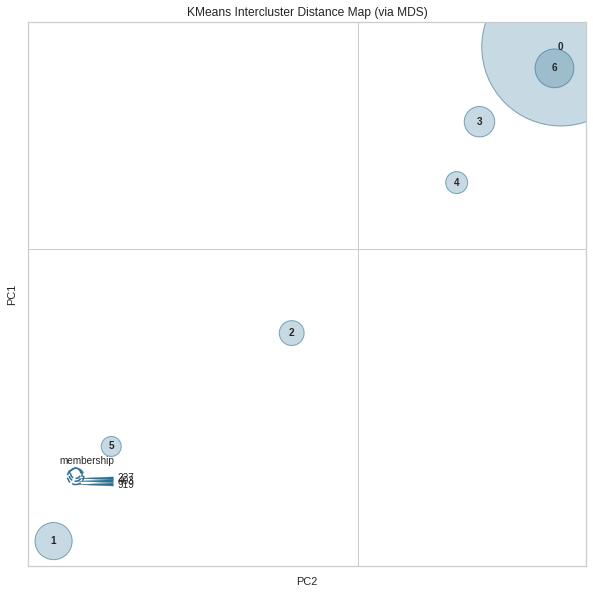

In [14]:
#Observando os clusters

plt.figure(figsize=(10,10))
# Instantiate the clustering model and visualizer
model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(data_obri)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()

## **NearestNeighboors**

***

Definindo auxiliares

In [15]:
def split(data):
    port_train,port_test=train_test_split(data,test_size=0.3,random_state=0)
    return port_train,port_test

In [16]:
def recommend(port_pre):
    
    nn_port_list = {}
    
    for row in range(port_pre.shape[0]):
        nn_port_list[row] = nn.kneighbors(port_pre.iloc[[row]].values)
        
    nn_size = len(nn_port_list)
    nn_num = len(nn_port_list[0][1][0])
    
    nn_index = nn_port_list[0][1][0]
    nn_distance = nn_port_list[0][0][0]
    
    np.delete(nn_index, [0,1])
    np.delete(nn_distance, [0,1])
    
    for i in range(1,nn_size):
        nn_index = np.concatenate((nn_index,nn_port_list[i][1][0]),axis=None)
        nn_distance = np.concatenate((nn_distance,nn_port_list[i][0][0]),axis=None)
        
    if len(nn_index) != nn_size*nn_num:
        print ('Erro')
    
    id_origin = {}
    
    for idx,ind in zip(nn_index,range(len(nn_index))):
        id_origin[ind] = (port_pre.iloc[int(ind/valor_nn)].name , market.iloc[idx].name, (nn_distance[ind]))
        
    recommend_train = pd.DataFrame.from_dict(id_origin,orient='index')
    recommend_train.rename(columns={0:'id_origin',1:'id',2:'distance'},inplace=True)
    recommend_train=recommend_train[recommend_train['id'].isin(port_pre.index)==0]  #tirando os conflitos
    recommend_train.set_index('id',inplace=True)
    suggestion = recommend_train.merge(market, how='left', left_index=True,right_index=True) ##unindo com o market
    suggestion = suggestion.loc[~suggestion.index.duplicated(keep='first')] ##tirando os duplicados   

    return suggestion

In [17]:
def test(port_test,recommend):
    acerto= ((port_test.index.isin(recommend.index).sum())/port_test.shape[0])*100
    return print('Acerto no teste:', acerto, '%')

In [18]:
def visualizar(data):
    for i in data.columns:
        if i == 'setor':
            sns.set(style="whitegrid")
            plt.figure(figsize=(20,10))
            sns.countplot(x="setor", data=data, palette="Reds_r",saturation=0.5)
            plt.title('Contagem dos Setores',fontsize=20)
            plt.xlabel('')
            plt.ylabel('')
            plt.show()
        if i == 'natureza_juridica_macro':
            sns.set(style="whitegrid")
            plt.figure(figsize=(20,10))
            sns.countplot(x="natureza_juridica_macro", data=data, palette="Reds_r",saturation=0.5)
            plt.title('Contagem da natureza jurídica',fontsize=20)
            plt.xlabel('')
            plt.ylabel('')
            plt.show()       
        if i == 'nm_meso_regiao':
            sns.set(style="whitegrid")
            plt.figure(figsize=(20,20))
            sns.countplot(y="nm_meso_regiao", data=data, palette="Reds_r",saturation=0.5)
            plt.title('Contagem Meso Região',fontsize=20)
            plt.xlabel('')
            plt.ylabel('')
            plt.show()
        if i == 'de_faixa_faturamento_estimado':
            sns.set(style="whitegrid")
            plt.figure(figsize=(20,20))
            sns.countplot(y="de_faixa_faturamento_estimado",hue='setor', data=data, palette="Reds_r",saturation=0.5)
            plt.title('Contagem do faturamento por setor',fontsize=20)
            plt.xlabel('')
            plt.ylabel('')
            plt.show()

***

In [21]:
valor_nn=5
nn= NearestNeighbors(n_neighbors=valor_nn,metric='cosine')
nn.fit(data_ohe_scaled)

NearestNeighbors(metric='cosine')

In [22]:
port1_train,port1_test=split(port1_pre)
port2_train,port2_test=split(port2_pre)
port3_train,port3_test=split(port3_pre)

In [23]:
recommend_port1 = recommend(port1_train)
recommend_port2 = recommend(port2_train)
recommend_port3 = recommend(port3_train)

In [24]:
test(port1_test,recommend_port1)
test(port2_test,recommend_port2)
test(port3_test,recommend_port3)

Acerto no teste: 2.3952095808383236 %
Acerto no teste: 37.64705882352941 %
Acerto no teste: 55.00000000000001 %


## Visualizações

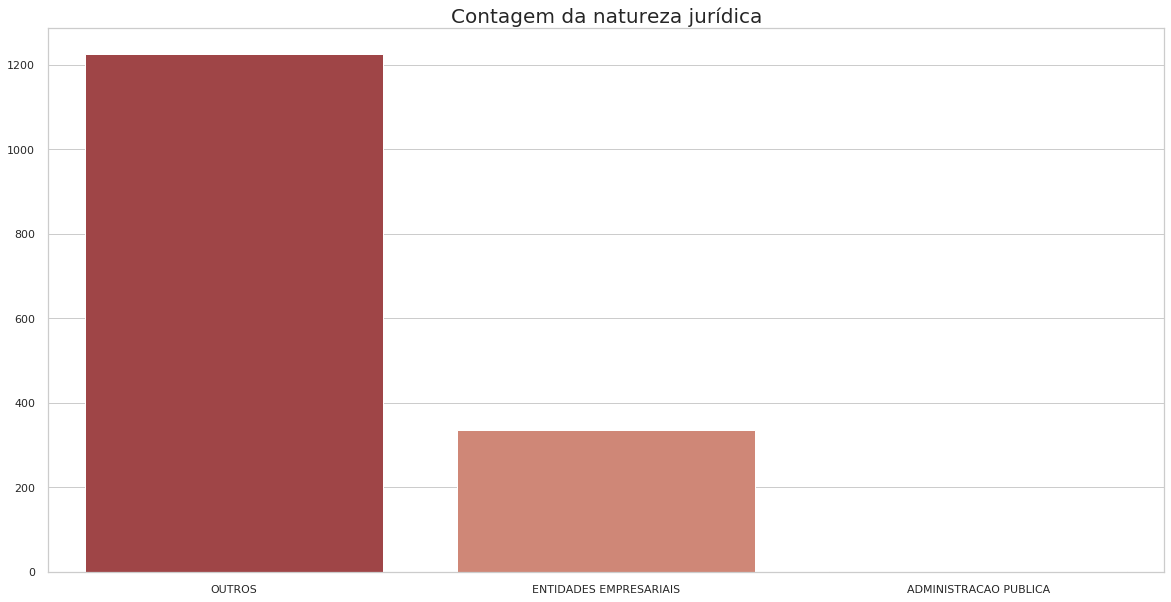

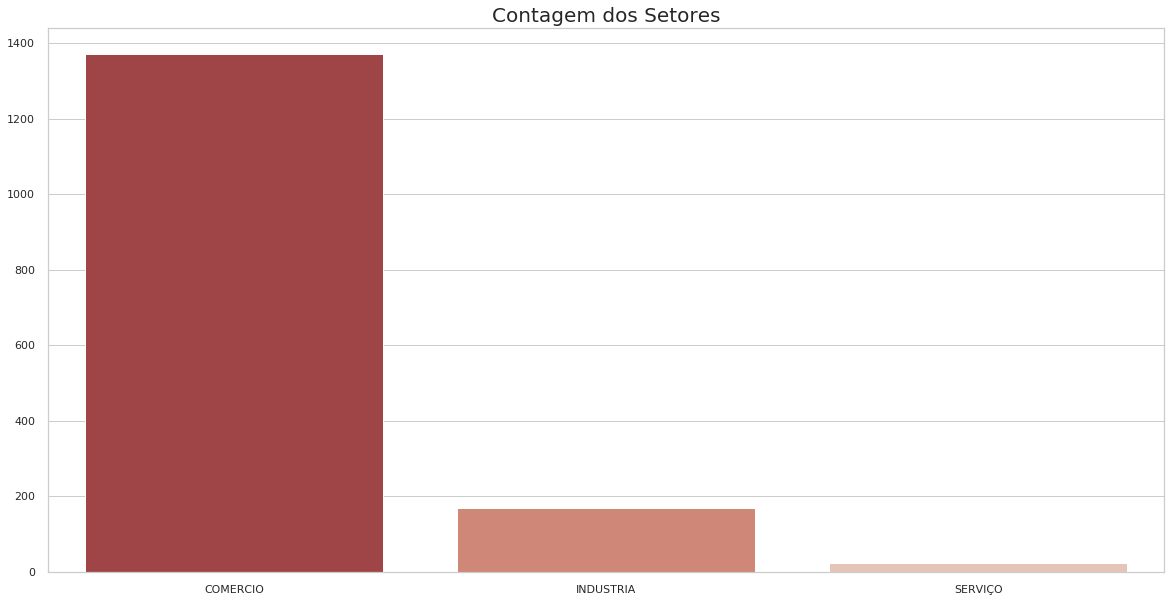

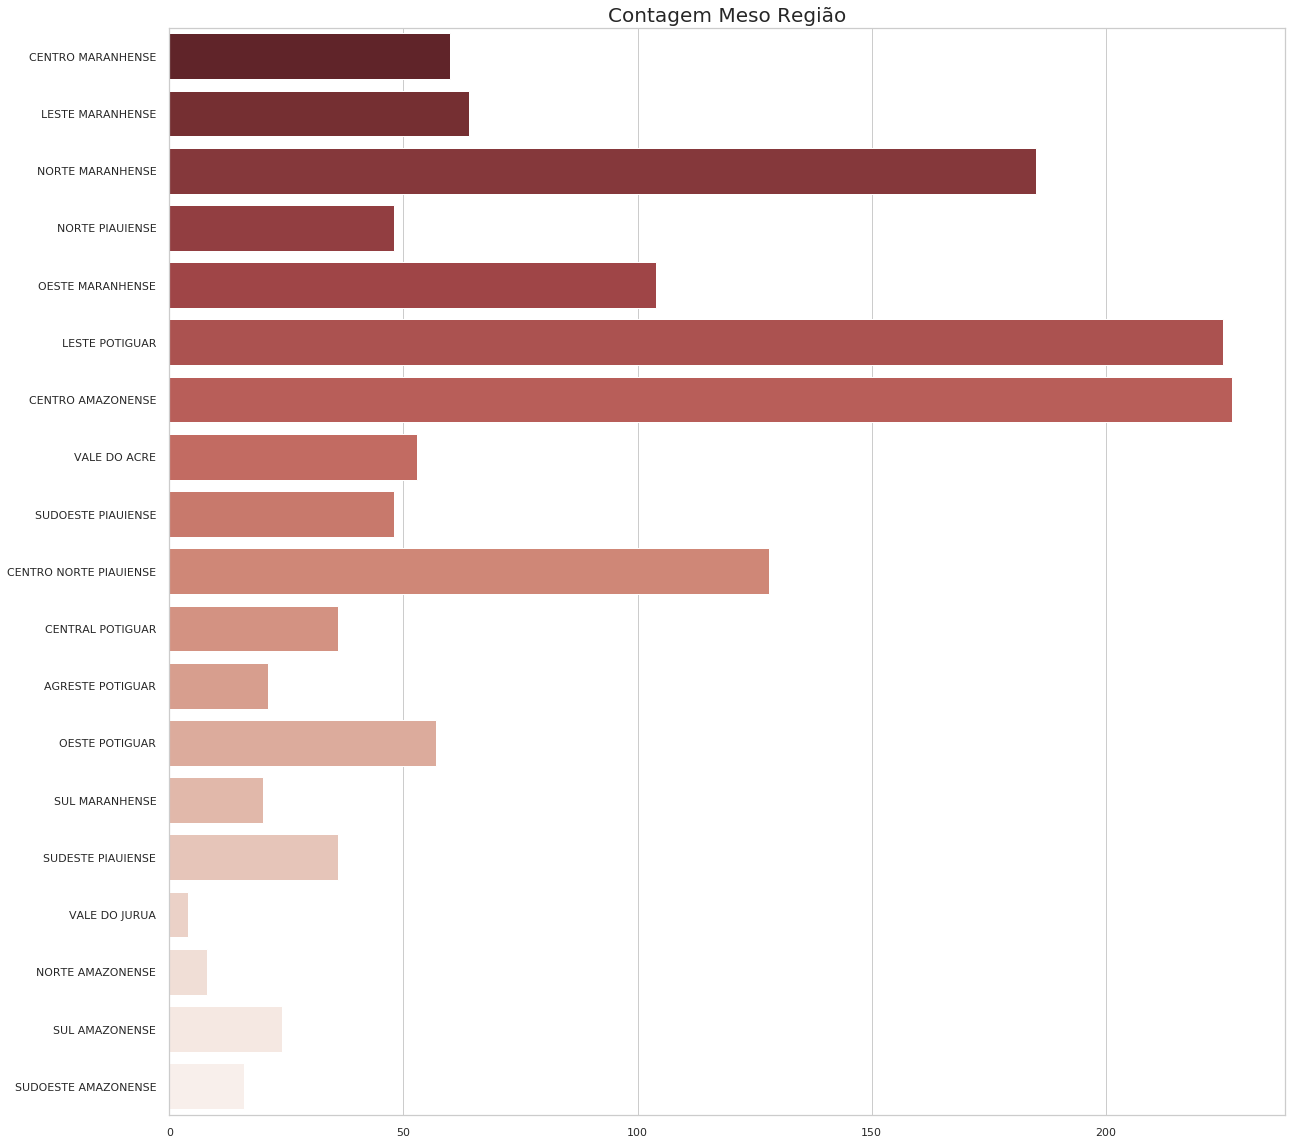

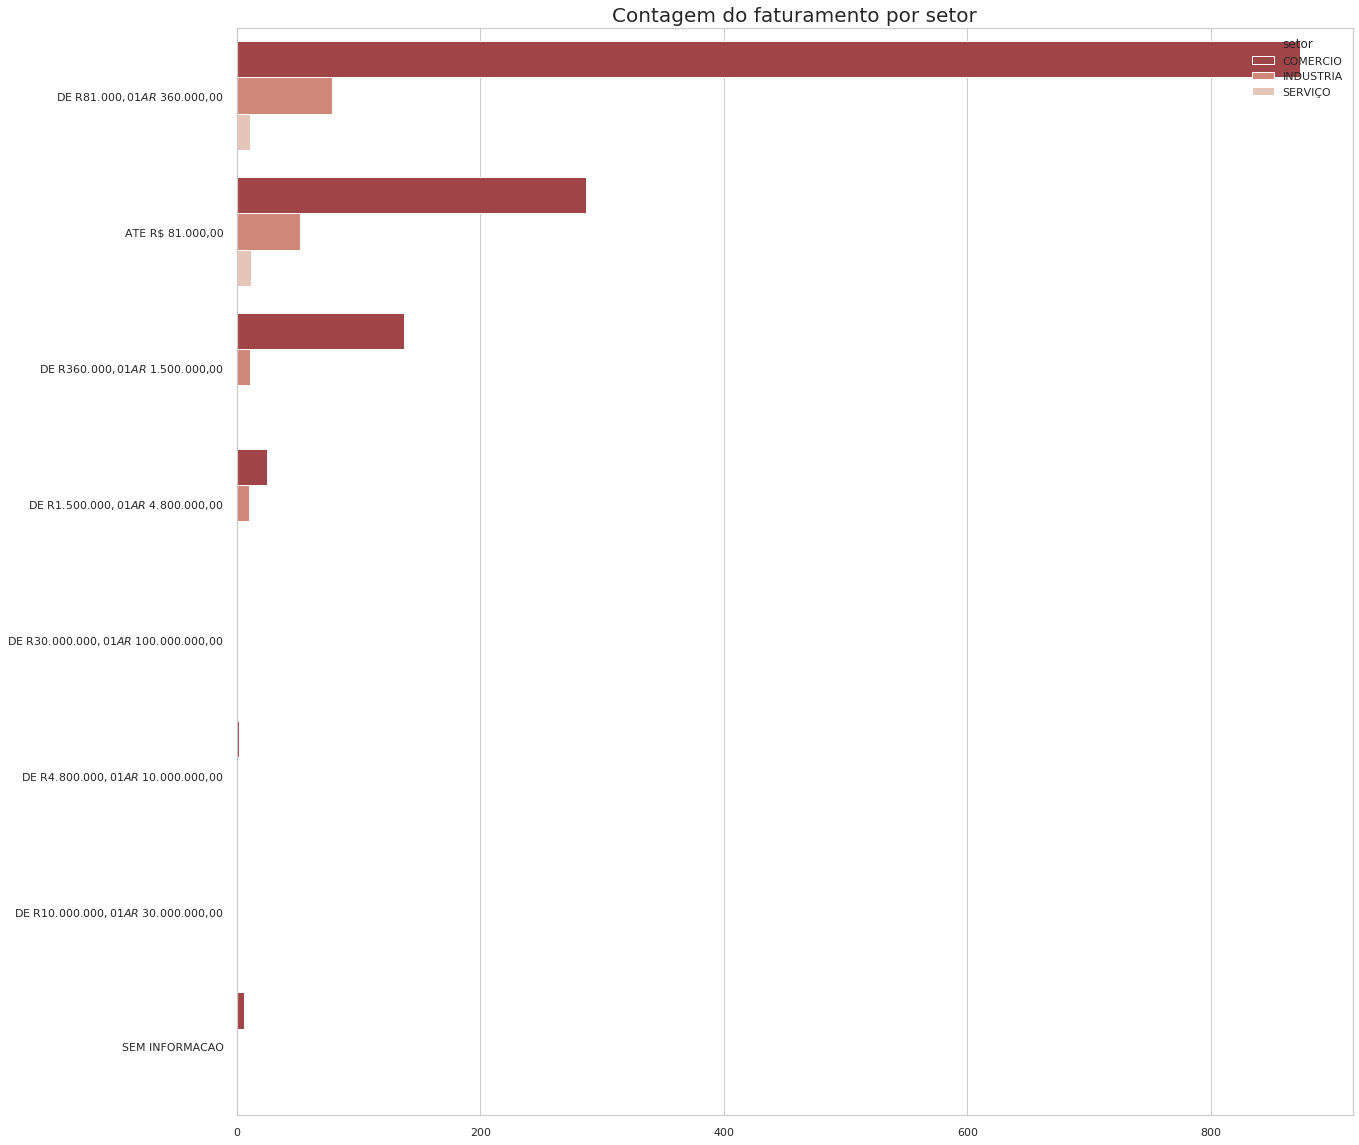

In [26]:
visualizar(recommend_port1)

### Definindo as localizações a partir de um banco de dados do governo

In [29]:
locations=pd.read_csv('data_2/municipios.csv')
locations.drop(['codigo_ibge','capital','codigo_uf'],axis=1,inplace=True)

In [32]:
locations['nome']=locations['nome'].apply(lambda x: unidecode.unidecode(x))
locations['nome']=locations['nome'].apply(lambda x: x.upper())

In [33]:
locations[locations['nome']=='MANAUS']

,nome,latitude,longitude
2885,MANAUS,-3.11866,-60.0212


In [34]:
coordenadas = []
null_count= 0
for local in recommend_port1['nm_micro_regiao']:
    
    coord=locations[locations['nome']==local][['latitude','longitude']]
    
    if not coord.empty:
        
        coordenadas.append([coord['latitude'].values[0]-random.uniform(0,0.25),
                            coord['longitude'].values[0]-random.uniform(0,0.25)])
    else:
        null_count += 1
print(null_count)

715


In [35]:
coordenadas_port = []
null_count_port= 0
for local in zip(port1[['nm_micro_regiao','de_ramo']].to_numpy()):
    coord=locations[locations['nome']==local[0][0]][['latitude','longitude']]
    if not coord.empty:
        coordenadas_port.append([coord['latitude'].values[0]-random.uniform(0,0.25),
                                coord['longitude'].values[0]-random.uniform(0,0.25),   
                                local[0][1]])
    else:
        null_count += 1
print(null_count_port)

0


In [40]:


m = folium.Map(location=[ -3.11866 ,-60.0212],
    zoom_start=4         )


for mark in coordenadas:
    folium.Marker([mark[0],mark[1]],icon=folium.Icon(icon='exclamation',color='darkred',prefix='fa')).add_to(m)

for mark in coordenadas_port:
    folium.Marker([mark[0],mark[1]],popup=mark[2],icon=folium.Icon(icon='home',color='pink')).add_to(m)


In [41]:
m

***

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import umap

In [23]:
umap_data = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3).fit_transform((data_ohe)[:20000].values)

/home/guireis/miniconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


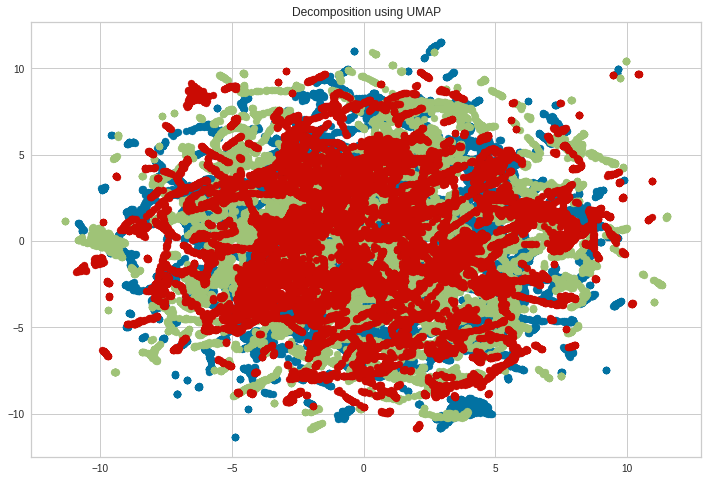

In [24]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using UMAP')
plt.scatter(umap_data[:,0], umap_data[:,1])
plt.scatter(umap_data[:,1], umap_data[:,2])
plt.scatter(umap_data[:,2], umap_data[:,0])

In [26]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3, n_iter=300).fit_transform(data_ohe[:6000].values)

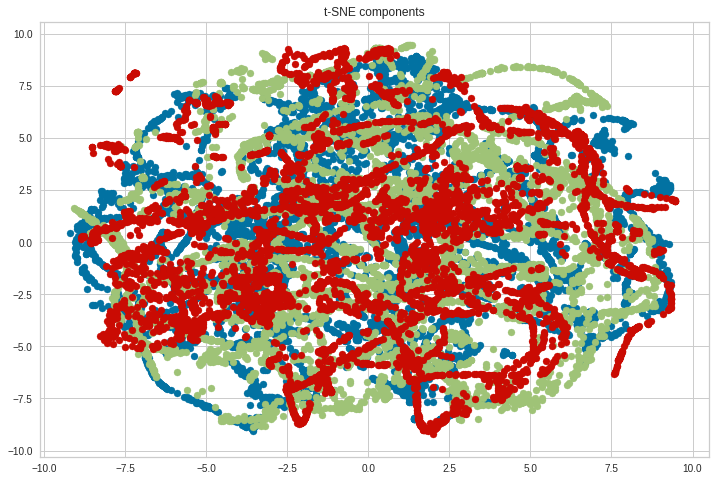

In [27]:
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(tsne[:,0], tsne[:,1])
plt.scatter(tsne[:,1], tsne[:,2])
plt.scatter(tsne[:,2], tsne[:,0])

In [28]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(data_ohe[:6000].values)

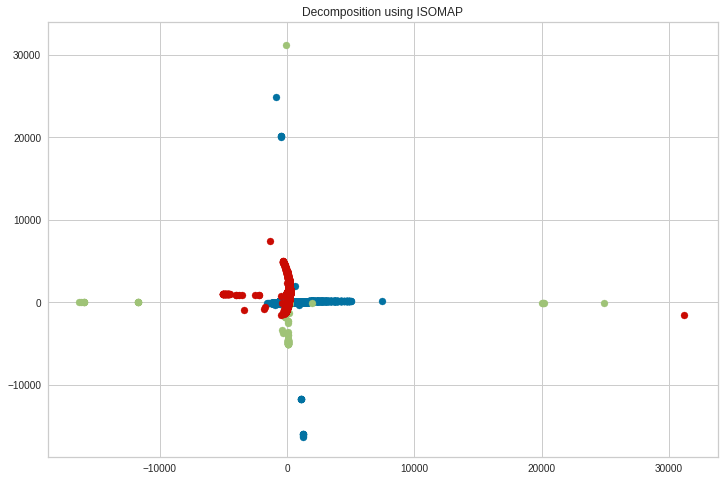

In [29]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using ISOMAP')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

In [93]:
col_pca=['fl_matriz',                                    'de_ramo',
                               'idade_emp_cat',
                                      'fl_mei',
                                    'fl_email',
                                 'fl_telefone',
                                       'fl_rm',
                                     'fl_antt',
                                  'fl_veiculo',
                         'de_saude_tributaria',
                          'de_nivel_atividade',
                             'fl_passivel_iss',
         'de_faixa_faturamento_estimado_grupo',
             'vl_total_veiculos_pesados_grupo',
               'vl_total_veiculos_leves_grupo',
       'empsetorcensitariofaixarendapopulacao',
                                   'qt_socios',
                          'idade_media_socios',
                             'qt_funcionarios',
                             'tx_rotatividade',
                                  'qt_filiais']

In [94]:
data_ohe_drop=data_ohe.drop(col_pca,axis=1)

In [105]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.8)
pca.fit(data_ohe_drop.values)
data_ohe_pca= pd.DataFrame(pca.transform(data_ohe_drop.values))

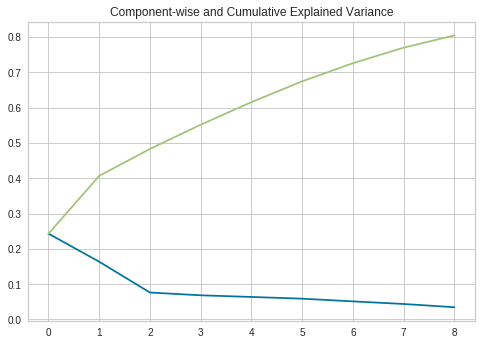

In [96]:
plt.plot(range(9), pca.explained_variance_ratio_)
plt.plot(range(9), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")
plt.show()

In [106]:
data_ohe_pca.set_index(data_ohe.index,inplace=True)

In [107]:
data_ohe_pca=pd.concat([data_ohe[col_pca],data_ohe_pca],axis=1)

In [109]:
valor_nn=5
nn= NearestNeighbors(n_neighbors=valor_nn,metric='cosine')
nn.fit(data_ohe_pca)

NearestNeighbors(metric='cosine')

In [110]:
port2_train,port2_test=split(port2_pre)

In [111]:
port2_train_drop=port2_train.drop(col_pca,axis=1)
port2_test_drop=port2_test.drop(col_pca,axis=1)

In [113]:
port2_train_pca = pd.DataFrame(pca.transform(port2_train_drop.values))
port2_test_pca = pd.DataFrame(pca.transform(port2_test_drop.values))

In [115]:
port2_test_pca.set_index(port2_test.index,inplace=True)
port2_train_pca.set_index(port2_train.index,inplace=True)

In [116]:
port2_test_pca=pd.concat([port2_test[col_pca],port2_test_pca],axis=1)
port2_train_pca=pd.concat([port2_train[col_pca],port2_train_pca],axis=1)

In [118]:
recommend_port2 = recommend(port2_train_pca)

In [119]:
test(port2_test_pca,recommend_port2)

Acerto no teste: 4.705882352941177 %


***

## Testando NNMF

In [19]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [20]:
nmf=NMF(n_components=6)

In [21]:
## portifolio 2
port2 = pd.read_csv('data/estaticos_portfolio2.csv')
port2.drop('Unnamed: 0',axis=1,inplace=True)
port2.set_index('id',inplace=True)

port2_nmf=data_ohe.merge(port2,how='right',left_index=True,right_index=True)
port2_nmf.dropna(inplace=True)

In [22]:
port2_train,port2_test=split(port2_nmf)

In [23]:
data_ohe_nmf=data_ohe.drop(['qt_socios','idade_media_socios'],axis=1)
port2_train_nmf=port2_train.drop(['qt_socios','idade_media_socios'],axis=1)
port2_test_nmf=port2_test.drop(['qt_socios','idade_media_socios'],axis=1)

In [24]:
nmf_port2_train = nmf.fit_transform(port2_train_nmf)

In [28]:
nmf_market = nmf.transform(data_ohe_nmf)
nmf_port2_test = nmf.transform(port2_test_nmf)

In [29]:
norm_market=pd.DataFrame(normalize(nmf_market),index=data_ohe_nmf.index)
norm_port2_train=pd.DataFrame(normalize(nmf_port2_train),index=port2_train.index)
norm_port2_test = pd.DataFrame(normalize(nmf_port2_test),index=port2_test.index)

In [30]:
norm_port2_train.head(2)

,0,1,2,3,4,5
id,,,,,,
7f0a205eaa026369144460c50aa3b34242cbfba65a9bfc8714c24693a2258dbc,0.917329,0.212359,0.297763,0.151555,0.042189,0.000681
099927213e8cf60291e8241bc78a1d92da8fbb2826ae30b45cad02dcc2ea19ba,0.993933,0.060817,0.000000,0.000137,0.049598,0.077063


In [31]:
norm_market.head(2)

,0,1,2,3,4,5
id,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.999665,0.005778,0.000485,0.000466,0.000453,0.025196
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.993690,0.000000,0.000847,0.000000,0.041537,0.104179


In [32]:
nmf_norm_list=pd.Series()
for i in range(len(norm_port2_train)):
    value = norm_market.dot(norm_port2_train.iloc[i]).nlargest(3)
    nmf_norm_list=pd.concat([nmf_norm_list,value])

In [33]:
nmf_norm_list = pd.DataFrame(nmf_norm_list)

In [34]:
norm_port2_test.shape

(170, 6)

In [35]:
nmf_norm_list.shape

(1182, 1)

In [36]:
norm_port2_test.index.isin(nmf_norm_list.index).sum()/norm_port2_test.shape[0]

0.2647058823529412